<hr>
<h1>Examples</h1>
<hr>

### Please see the [scikit-image documentation](https://scikit-image.org/docs/stable/index.html), especially:
- [User Guide](https://scikit-image.org/docs/stable/user_guide.html)
- [Examples](https://scikit-image.org/docs/stable/auto_examples/)

Import numpy and matplotlib

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Aside: How to find?

In [2]:
np.lookfor('otsu', 'skimage')

Search results for 'otsu'
-------------------------
skimage.filters.rank.otsu
    Local Otsu's threshold value for each pixel.
skimage.filters.threshold_otsu
    Return threshold value based on Otsu's method.
skimage.filters.try_all_threshold
    Returns a figure comparing the outputs of different thresholding methods.


## Data

In [3]:
from pathlib import Path
from skimage.io import imread
from skimage import img_as_float

data_dir = Path('..') / 'data'
blobs = imread(str(data_dir/'ij-samples'/'blobs.gif'))
blobs = img_as_float(blobs)

In [4]:
f = '4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06.tif'
image = imread(str(data_dir.joinpath('dsb2018','train','images',f)))

## Exposure

Outlier-robust normalization (constrast, brightness)

In [5]:
from skimage import exposure

low, high = np.percentile(image, (3, 99.8))
x = exposure.rescale_intensity(image, in_range=(low, high))
x = img_as_float(x)

## alternative
# from csbdeep.utils import normalize
# x = normalize(image, 3, 99.8, clip=True)

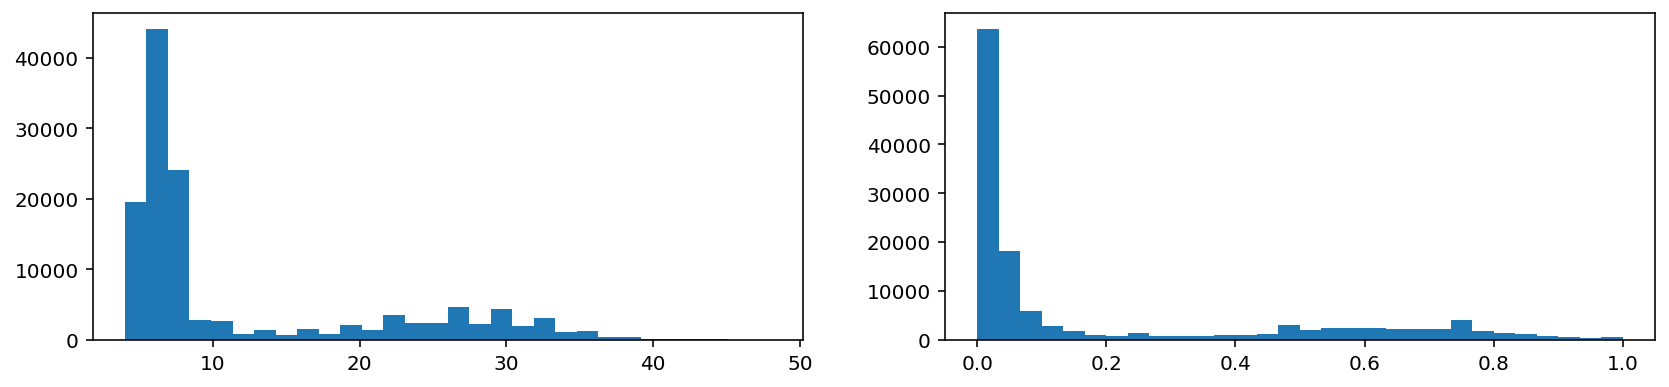

In [6]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1); plt.hist(image.ravel(), bins=30)
plt.subplot(1,2,2); plt.hist(x.ravel(),     bins=30)
None;

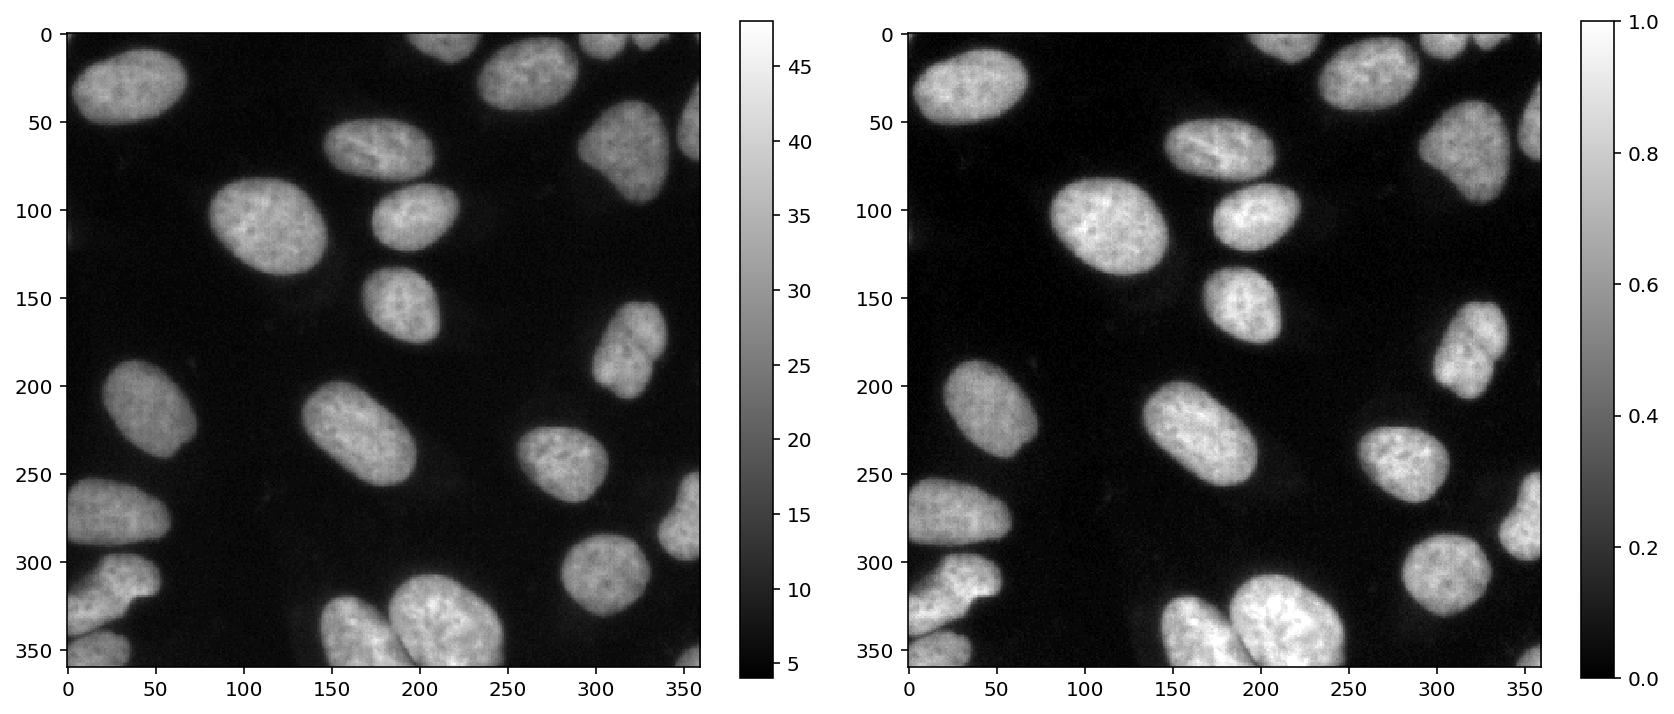

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(image, cmap='gray'); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(x, clim=(0,1), cmap='gray'); plt.colorbar()
plt.tight_layout()
None;

## Transform

Recaling and rotating

/Users/uwe/anaconda3/envs/ts13/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


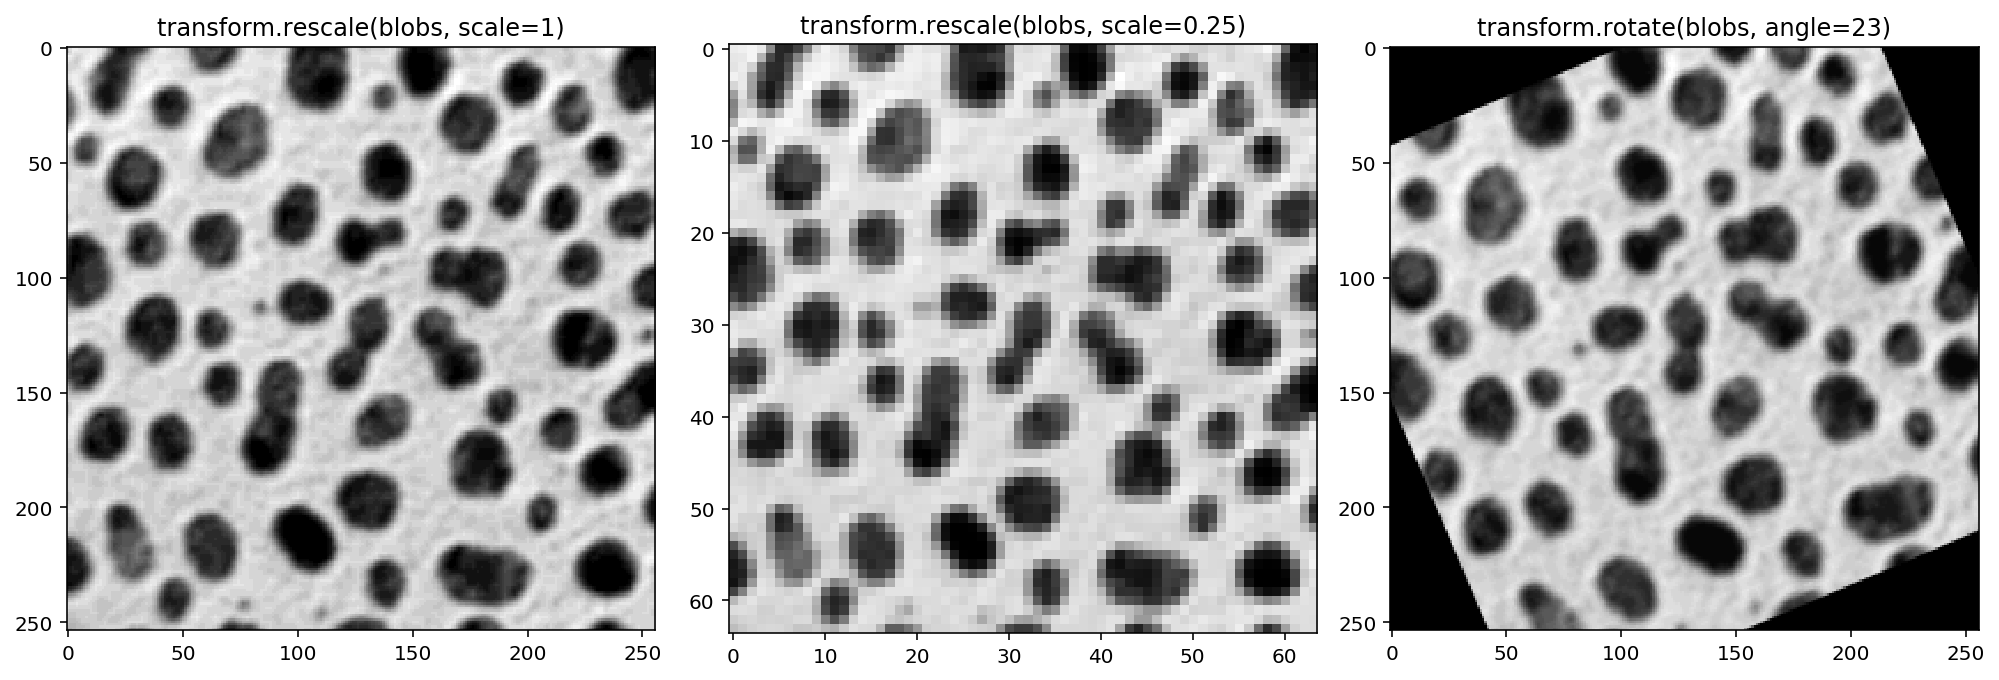

In [8]:
from skimage import transform

example_transforms = (
    ('transform.rescale', dict(scale=1)),
    ('transform.rescale', dict(scale=0.25)),
    ('transform.rotate', dict(angle=23)),
)

fig, ax = plt.subplots(1,len(example_transforms), figsize=(14,10))

for a, (tform, tform_kwargs) in zip(ax.ravel(), example_transforms):
    a.imshow(eval(tform)(blobs, **tform_kwargs), cmap='gray')
    t = ", ".join([f"{k}={v}" for k,v in tform_kwargs.items()])
    a.set_title(f"{tform}(blobs{', '+t if len(t)>0 else ''})")

plt.tight_layout()
#[a.axis('off') for a in ax.ravel()]
None;

## Filters

/Users/uwe/anaconda3/envs/ts13/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


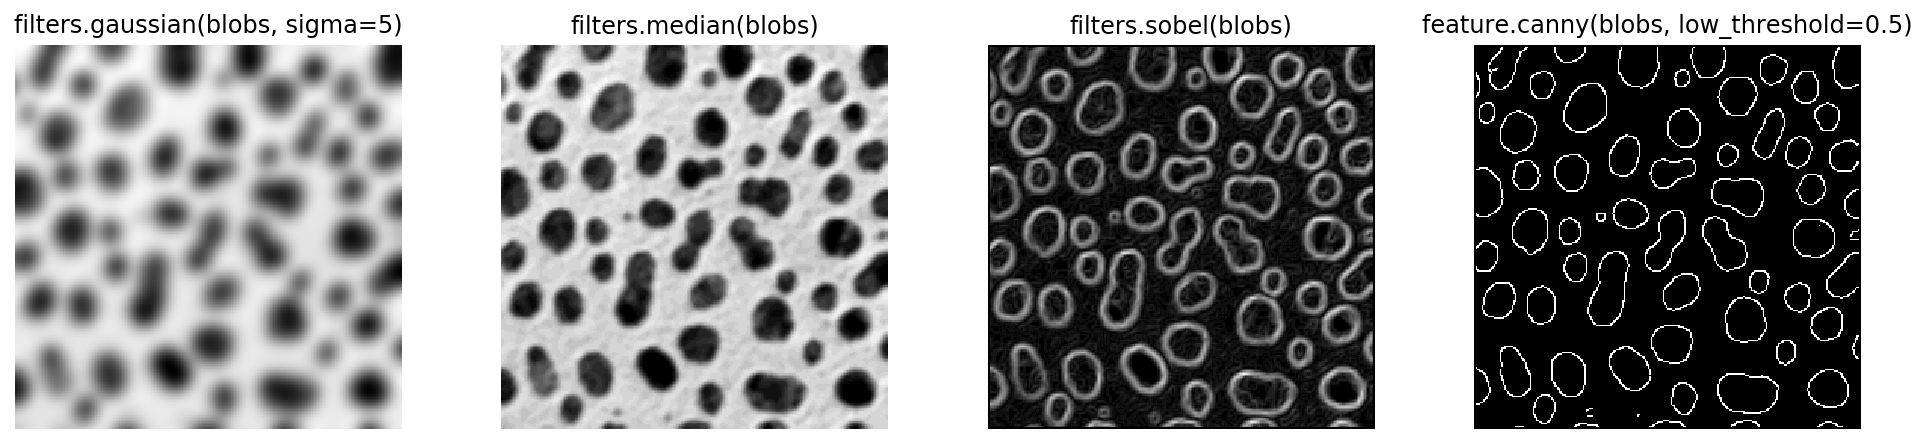

In [9]:
from skimage import filters, feature

example_filters = (
    ('filters.gaussian', dict(sigma=5)),
    ('filters.median', dict()),
    ('filters.sobel', dict()),
    ('feature.canny', dict(low_threshold=0.5)),
)

fig, ax = plt.subplots(1,len(example_filters), figsize=(14,10))

for a, (filt, filt_kwargs) in zip(ax.ravel(), example_filters):
    a.imshow(eval(filt)(blobs, **filt_kwargs), cmap='gray')
    t = ", ".join([f"{k}={v}" for k,v in filt_kwargs.items()])
    a.set_title(f"{filt}(blobs{', '+t if len(t)>0 else ''})")

plt.tight_layout()
[a.axis('off') for a in ax.ravel()]
None;

## Segmentation

### Thresholding

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


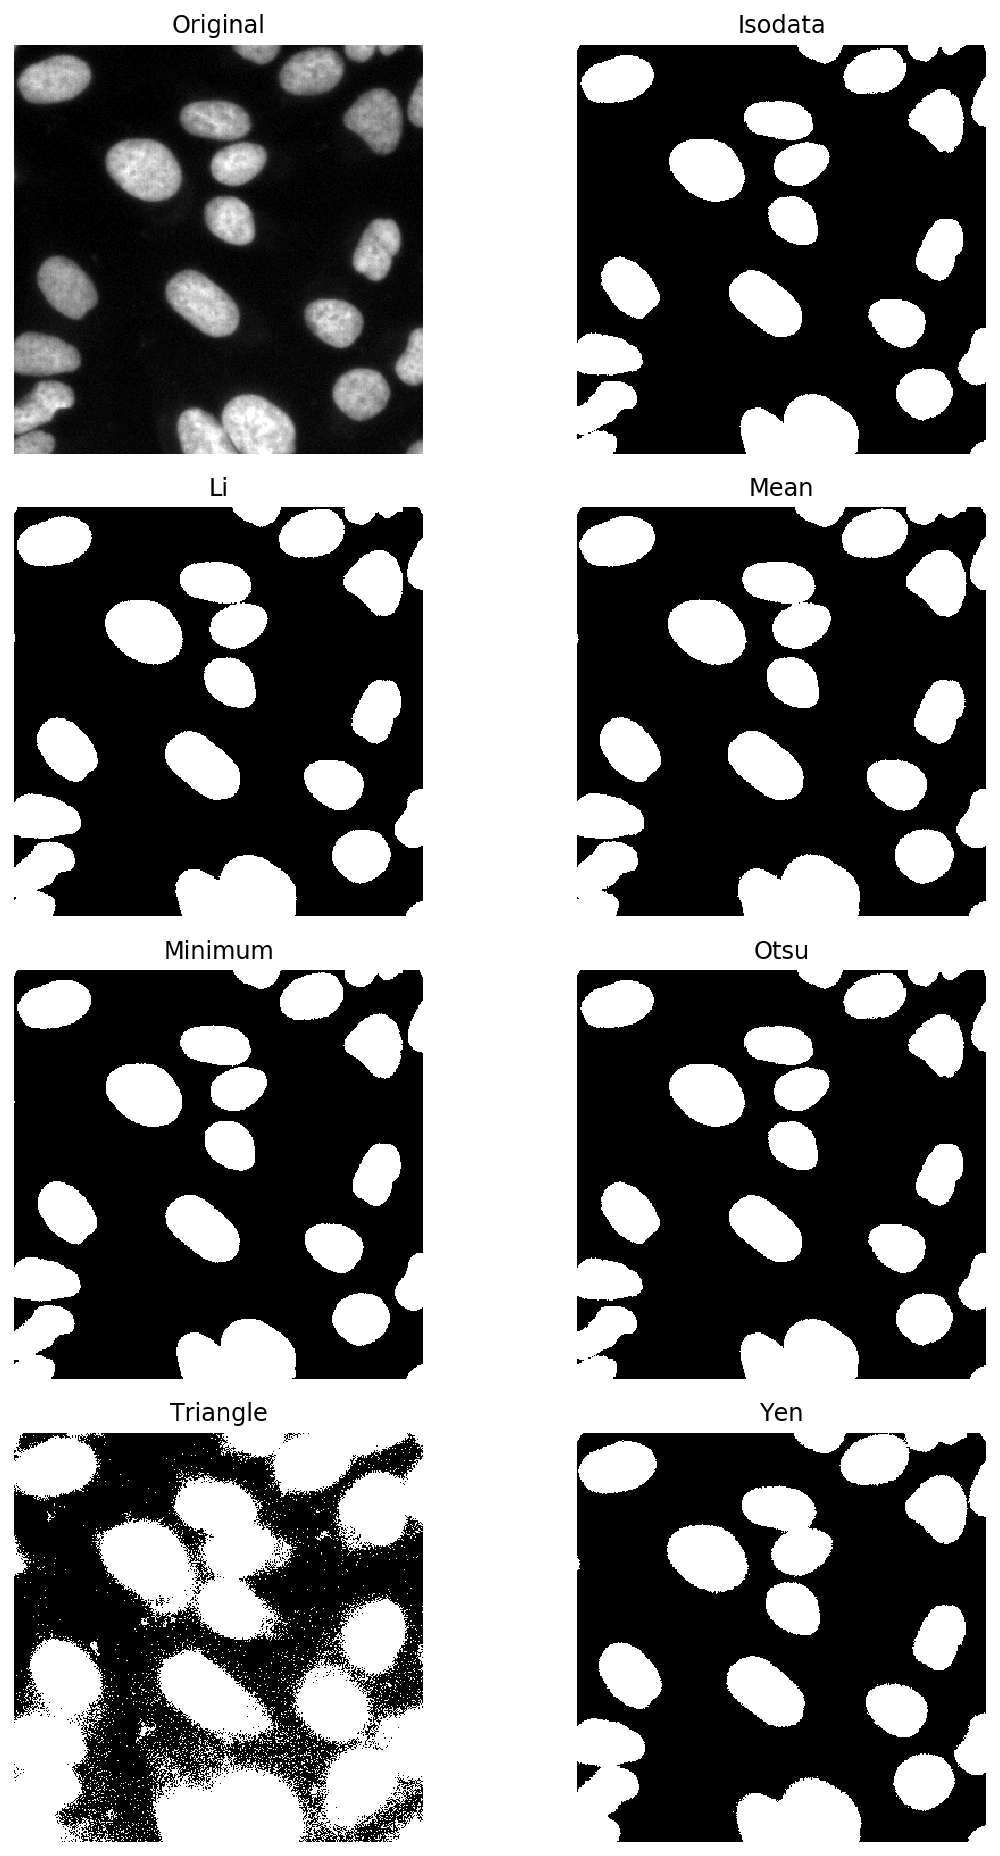

In [10]:
filters.try_all_threshold(x, figsize=(9,13));

### Small workflow

- Image thresholding
- Connected components (using [scipy](https://scipy.org/))
- (Morphological opening)
- Display

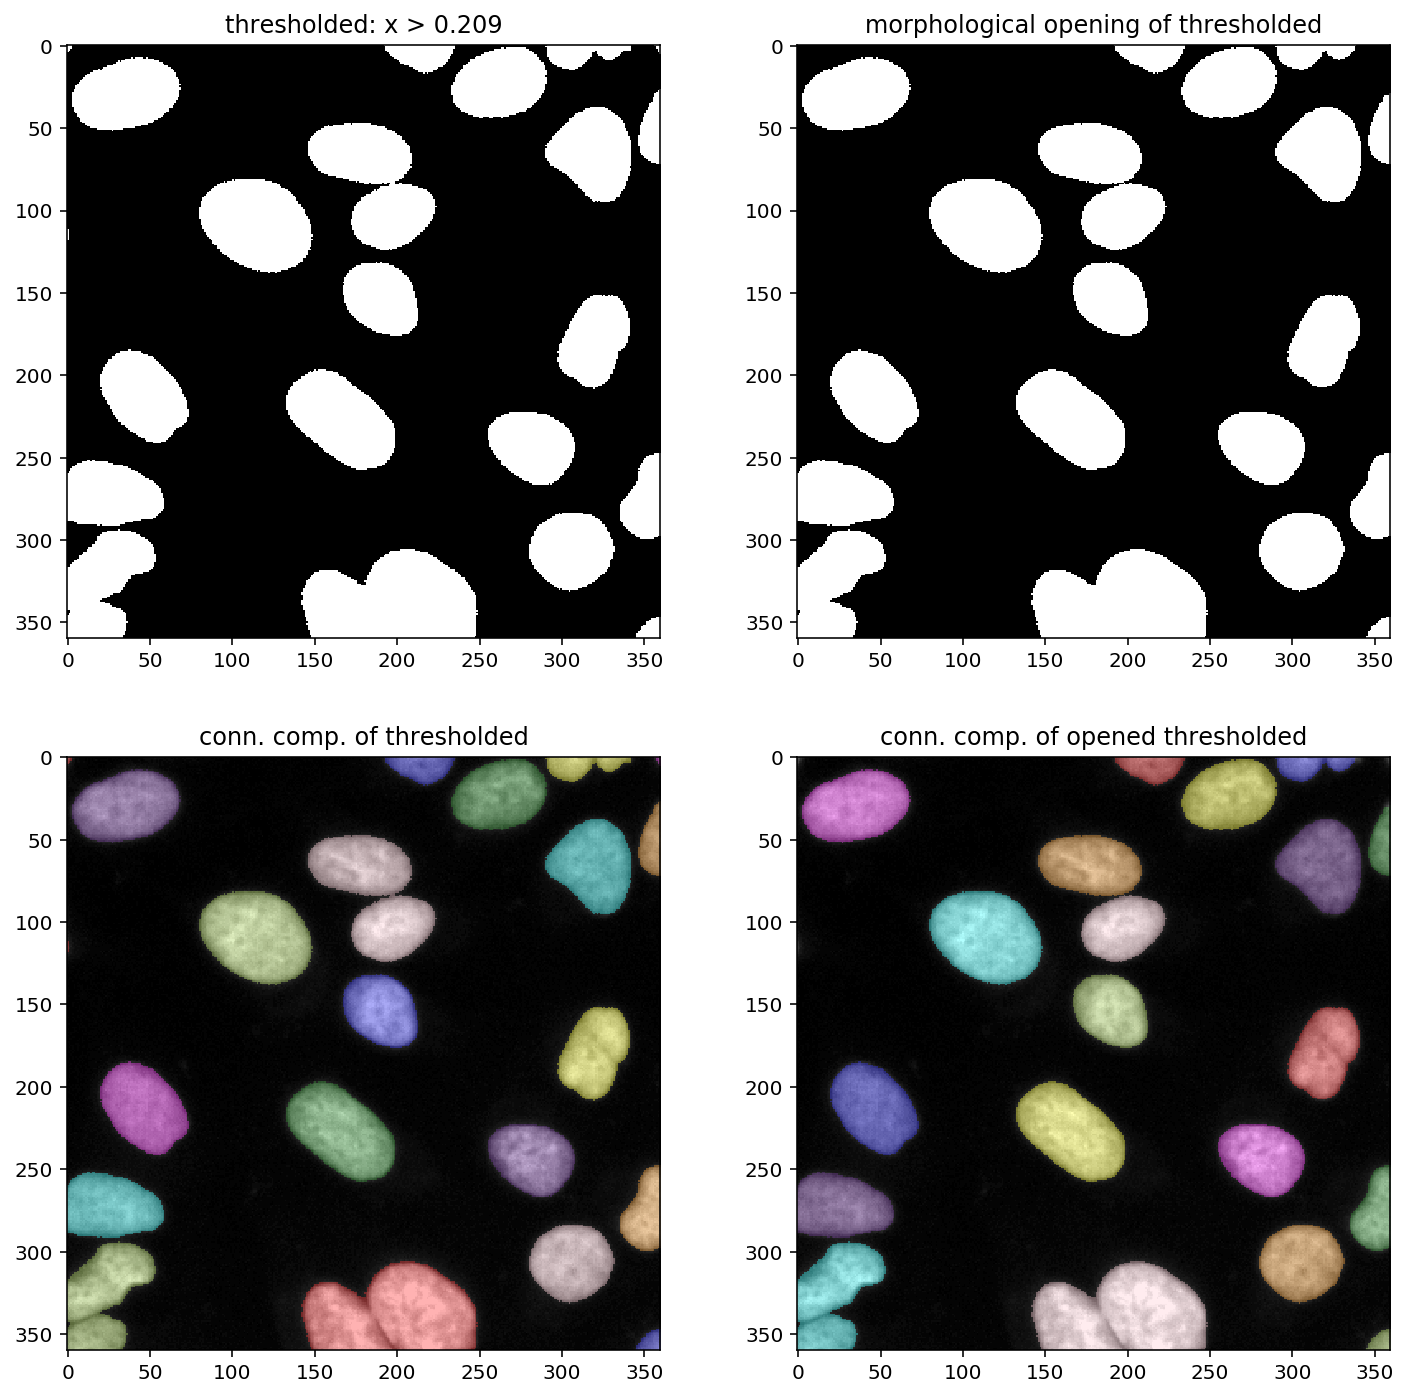

In [11]:
from skimage.color import label2rgb
from skimage.morphology import opening, disk
from scipy.ndimage import label

thresh = filters.threshold_li(x)
x_thresholded = x > thresh
labels = label(x_thresholded)[0]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(x_thresholded, cmap='gray')
plt.title(f"thresholded: x > {thresh:.3}")
plt.subplot(2,2,3)
plt.imshow(label2rgb(labels, image=x, bg_label=0))
plt.title(f"conn. comp. of thresholded")

x_thr_opened = opening(x_thresholded, selem=disk(5))
labels = label(x_thr_opened)[0]

plt.subplot(2,2,2)
plt.imshow(x_thr_opened, cmap='gray')
plt.title("morphological opening of thresholded")
plt.subplot(2,2,4)
plt.imshow(label2rgb(labels, image=x, bg_label=0))
plt.title(f"conn. comp. of opened thresholded")
None;

### Another workflow

- Image thresholding
- Euclidean distance transform
- Find local maxima
- Use maxima as seeds for watershed
- Connected components (using [scipy](https://scipy.org/))
- (Morphological opening)
- Display

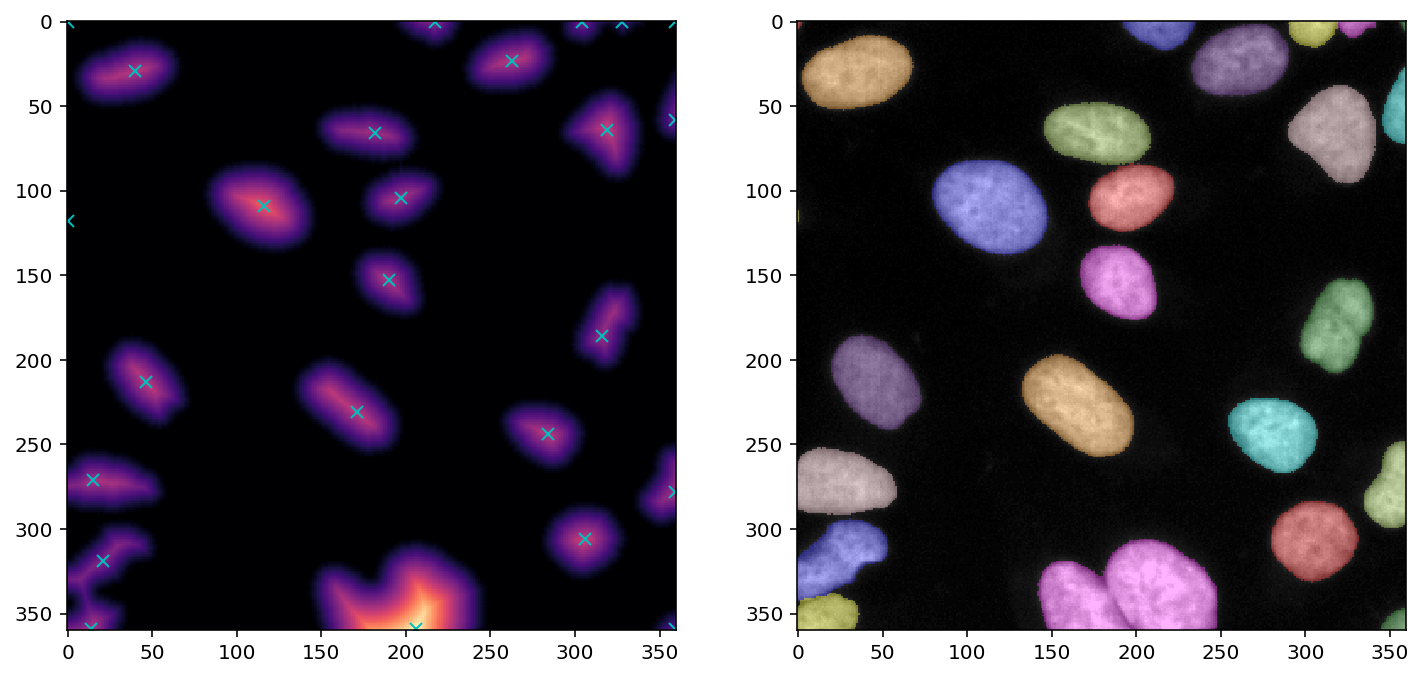

In [12]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt

dist = distance_transform_edt(x_thresholded)
dist += np.random.uniform(0,1e-3,size=dist.shape) # bad hack: tiebreaker for identical dist values

peaks = peak_local_max(dist, min_distance=15, indices=False, labels=x_thresholded, exclude_border=False)
markers = label(peaks)[0]
labels = watershed(-dist, markers=markers, mask=x_thresholded)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(dist, cmap='magma')
rr,cc = np.nonzero(peaks)
plt.plot(cc,rr,'xc')
plt.subplot(1,2,2)
plt.imshow(label2rgb(labels, image=x, bg_label=0))
None;

## Measurements & Analysis

In [13]:
from skimage.measure import regionprops

regions = regionprops(labels, intensity_image=image)

In [14]:
[print(a) for a in dir(regions[0]) if not a.startswith('_')];

area
bbox
bbox_area
centroid
convex_area
convex_image
coords
eccentricity
equivalent_diameter
euler_number
extent
filled_area
filled_image
image
inertia_tensor
inertia_tensor_eigvals
intensity_image
label
local_centroid
major_axis_length
max_intensity
mean_intensity
min_intensity
minor_axis_length
moments
moments_central
moments_hu
moments_normalized
orientation
perimeter
slice
solidity
weighted_centroid
weighted_local_centroid
weighted_moments
weighted_moments_central
weighted_moments_hu
weighted_moments_normalized


Areas: [7, 12, 15, 141, 154, 365, 447, 527, 684, 930, 1551, 1582, 1647, 1749, 1771, 1861, 1871, 1894, 1931, 2090, 2126, 2204, 2655, 2964, 4486]


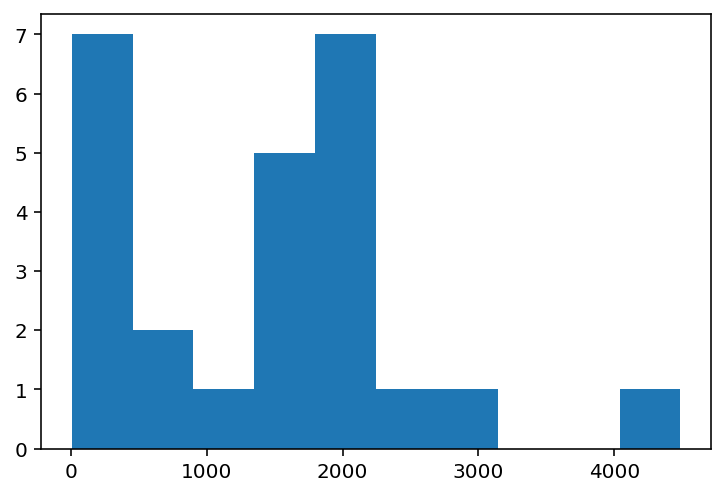

In [15]:
plt.hist([r.area for r in regions])
print("Areas:", sorted([r.area for r in regions]));

In [16]:
import pandas as pd

attributes = ['label', 'area', 'centroid', 'mean_intensity']
data = {attr: [getattr(r,attr) for r in regions] for attr in attributes}
data['centroid_row'] = [c[0] for c in data['centroid']]
data['centroid_col'] = [c[1] for c in data['centroid']]
del data['centroid']
df = pd.DataFrame(data, index=data['label'])

In [17]:
df

,label,area,mean_intensity,centroid_row,centroid_col
1,1,12,17.166667,1.583333,0.833333
2,2,527,21.821632,6.425047,214.415560
3,3,365,23.079452,6.147945,304.273973
4,4,154,21.259740,3.376623,329.512987
5,5,15,17.133333,1.866667,358.066667
6,6,1931,23.093216,23.253755,261.956499
7,7,2204,25.740018,30.139746,35.297187
8,8,447,21.684564,52.539150,353.892617
9,9,2126,21.611007,65.667451,318.650988
10,10,1861,24.236432,65.774852,177.418055


In [18]:
df.head()

,label,area,mean_intensity,centroid_row,centroid_col
1,1,12,17.166667,1.583333,0.833333
2,2,527,21.821632,6.425047,214.415560
3,3,365,23.079452,6.147945,304.273973
4,4,154,21.259740,3.376623,329.512987
5,5,15,17.133333,1.866667,358.066667


In [19]:
df.head().T

,1,2,3,4,5
label,1.000000,2.000000,3.000000,4.000000,5.000000
area,12.000000,527.000000,365.000000,154.000000,15.000000
mean_intensity,17.166667,21.821632,23.079452,21.259740,17.133333
centroid_row,1.583333,6.425047,6.147945,3.376623,1.866667
centroid_col,0.833333,214.415560,304.273973,329.512987,358.066667


In [20]:
df.describe()

,label,area,mean_intensity,centroid_row,centroid_col
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,13.000000,1426.560000,23.794044,152.563422,197.654033
std,7.359801,1097.556797,3.874393,126.690270,130.104242
min,1.000000,7.000000,14.000000,1.583333,0.000000
25%,7.000000,447.000000,21.684564,30.139746,46.022010
50%,13.000000,1647.000000,23.624269,115.000000,196.942618
75%,19.000000,1931.000000,26.564663,272.792503,318.650988
max,25.000000,4486.000000,31.050825,354.226950,358.066667


In [21]:
q = (df.query('1000 < area < 2000')
       .query('mean_intensity > 25'))
q

,label,area,mean_intensity,centroid_row,centroid_col
11,11,1551,27.610574,103.606705,196.942618
14,14,1582,27.549305,153.878003,190.083439
15,15,1749,26.107490,179.212693,319.307033
18,18,1771,26.267645,243.173913,281.505929
21,21,1871,25.194548,306.341529,305.272582
22,22,1647,26.564663,316.567699,24.304189


In [22]:
print(q.to_csv())

,label,area,mean_intensity,centroid_row,centroid_col
11,11,1551,27.6105738233,103.606705351,196.942617666
14,14,1582,27.5493046776,153.878002528,190.083438685
15,15,1749,26.1074899943,179.212692967,319.30703259
18,18,1771,26.2676453981,243.173913043,281.505928854
21,21,1871,25.1945483699,306.341528594,305.272581507
22,22,1647,26.5646630237,316.567698846,24.3041894353



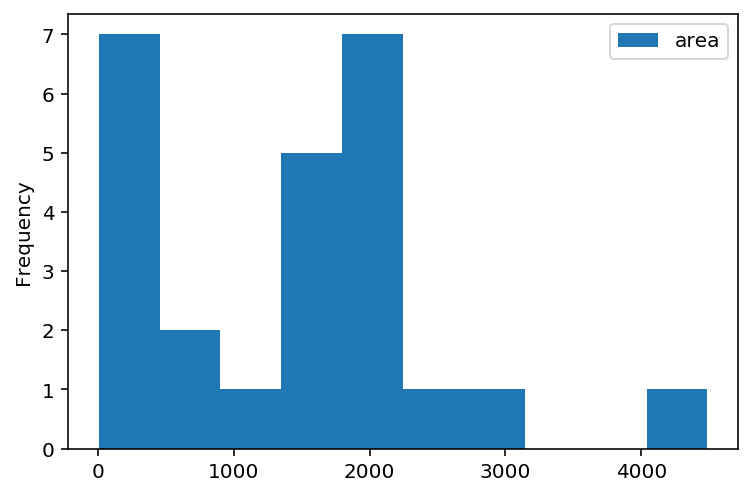

In [23]:
df[['area']].plot.hist();

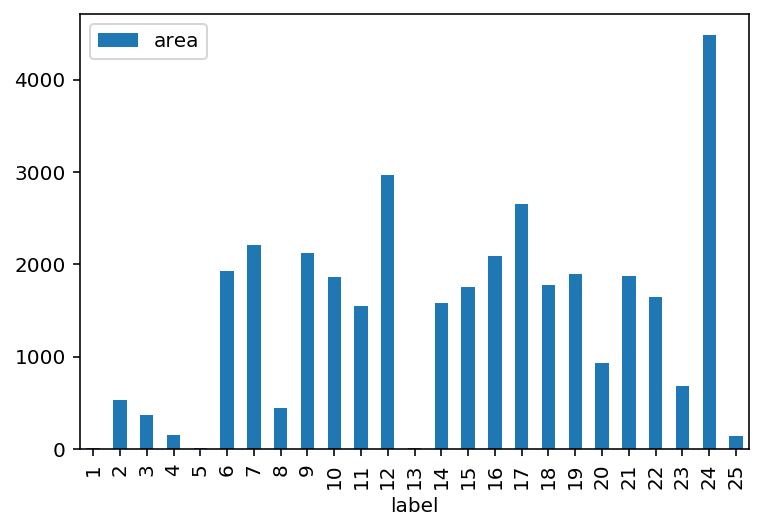

In [24]:
df.plot.bar(x='label',y='area');

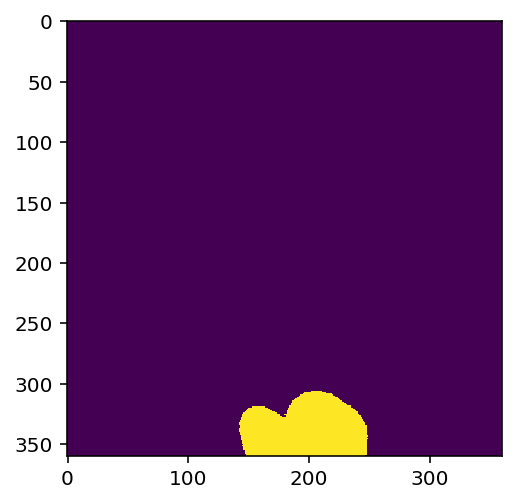

In [25]:
plt.imshow(labels==24);

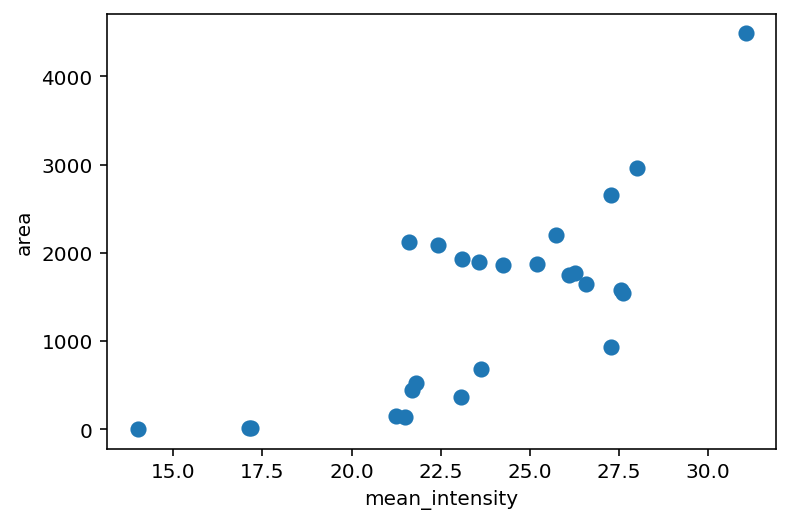

In [26]:
df.plot.scatter(x='mean_intensity', y='area', s=50);

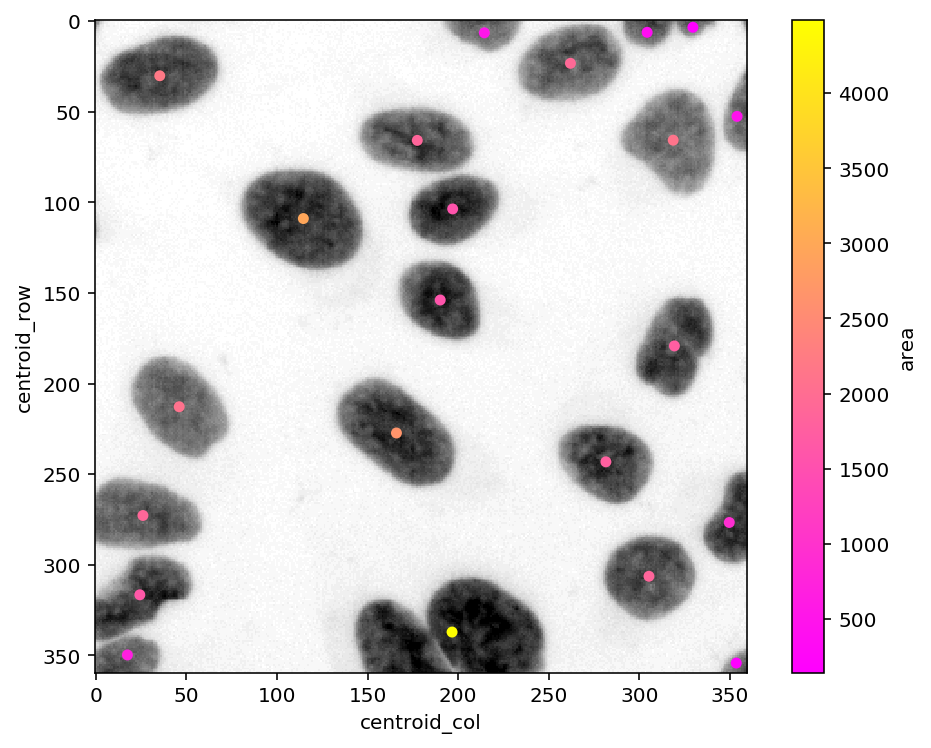

In [27]:
plt.figure(figsize=(8,6))
plt.imshow(x, cmap='gray_r')
(df
.query('area > 50')
.plot.scatter(x='centroid_col', y='centroid_row', c='area', colormap='spring', ax=plt.gca()));